<a href="https://colab.research.google.com/github/ravitata/nlp/blob/main/named_entity_recognition_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install seqeval

     |████████████████████████████████| 3.8 MB 20.4 MB/s 
     |████████████████████████████████| 596 kB 21.4 MB/s 
     |████████████████████████████████| 6.5 MB 52.2 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 60.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 311 kB 29.8 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 134 kB 72.5 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 144 kB 66.8 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=290382bec3d91752

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "It's 7 a.m. in Kyiv as Russia's invasion enters a second week."

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-LOC', 'score': 0.9997259, 'index': 10, 'word': 'K', 'start': 15, 'end': 16}, {'entity': 'I-LOC', 'score': 0.9949397, 'index': 11, 'word': '##yi', 'start': 16, 'end': 18}, {'entity': 'I-LOC', 'score': 0.9859648, 'index': 12, 'word': '##v', 'start': 18, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999835, 'index': 14, 'word': 'Russia', 'start': 23, 'end': 29}]


In [4]:
from transformers import DistilBertTokenizer, TFDistilBertForTokenClassification
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
input_ids = inputs["input_ids"]
inputs["labels"] = tf.reshape(tf.constant([1] * tf.size(input_ids).numpy()), (-1, tf.size(input_ids))) # Batch size 1

outputs = model(inputs)
loss, scores = outputs[:2]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

In [5]:
loss

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.6443278 , 0.53839356, 0.772532  , 0.7116108 , 0.75409955,
       0.77341545, 0.9679525 , 1.0118706 ], dtype=float32)>

In [6]:
scores

<tf.Tensor: shape=(1, 8, 2), dtype=float32, numpy=
array([[[-0.20738761, -0.10724264],
        [-0.31500816,  0.02291181],
        [-0.24508327, -0.39801165],
        [-0.2506823 , -0.28727463],
        [ 0.01320804, -0.10519394],
        [-0.13898432, -0.2935538 ],
        [ 0.09087286, -0.39926955],
        [-0.02822313, -0.58826274]]], dtype=float32)>

In [7]:
import pandas as pd
import tensorflow as tf
import json
import random
import logging
import re

In [8]:
df_data = pd.read_json("ner.json", lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [9]:
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [10]:
df_data.iloc[0]['annotation']

[{'label': ['Skills'],
  'points': [{'end': 1621,
    'start': 1295,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'end': 1153,
    'start': 993,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'end': 956, 'start': 939, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'end': 904, 'start': 883, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'end': 860, 'start': 856, 'text': '2017\n'}]},
 {'label': ['College 

In [11]:
def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)
    return merged

https://www.kaggle.com/alincijov/conll-huggingface-named-entity-recognition/notebook

In [1]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    
    return final

In [4]:
base_path = '/content/'

train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = ['_'] + sorted({tag for sentence in samples 
                             for _, tag in sentence})

In [5]:
print(len(train_samples))
print(len(test_samples))
print(len(valid_samples))


14041
3453
3250


In [6]:
train_samples[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [7]:
schema

['_',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O']

In [8]:
type(schema)

list

In [9]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 6.5 MB 36.9 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-cased' 

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                          config=config,)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 107,727,370
Trainable params: 107,727,370
Non-trainable params: 0
_________________________________________________________________


In [11]:
config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "t

In [12]:
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

14041it [00:15, 881.90it/s]
3453it [00:03, 957.66it/s] 
3250it [00:03, 818.90it/s]


In [12]:
type(X_train)

numpy.ndarray

In [13]:
print(X_train[0])
print(y_train[0])

[    3  7270 22961  1528  1840  1106 21423  1418  2495 12913   119     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [14]:
import tensorflow as tf

EPOCHS=3
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(lr=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(tf.constant(X_train), tf.constant(y_train),
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
439/439 [==============================] - 999s 2s/step - loss: 0.3113 - accuracy: 0.9359 - val_loss: 0.1293 - val_accuracy: 0.9690
Epoch 2/3
439/439 [==============================] - 967s 2s/step - loss: 0.1094 - accuracy: 0.9722 - val_loss: 0.0937 - val_accuracy: 0.9721
Epoch 3/3
439/439 [==============================] - 969s 2s/step - loss: 0.0775 - accuracy: 0.9772 - val_loss: 0.0672 - val_accuracy: 0.9786


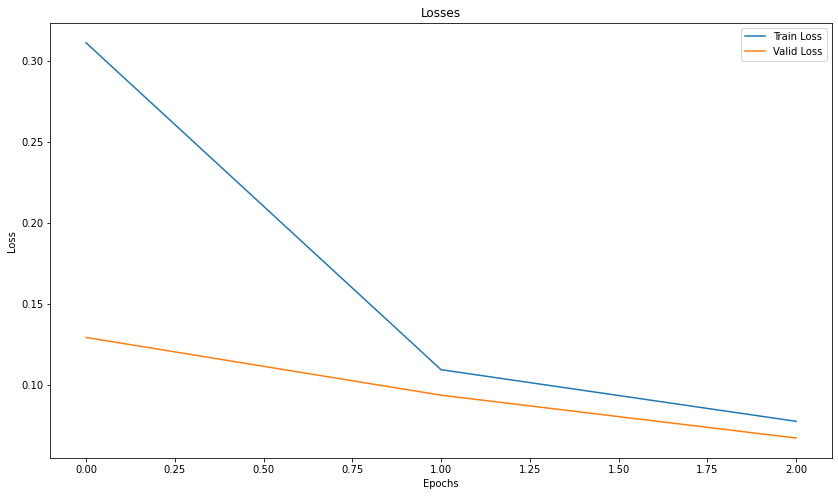

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

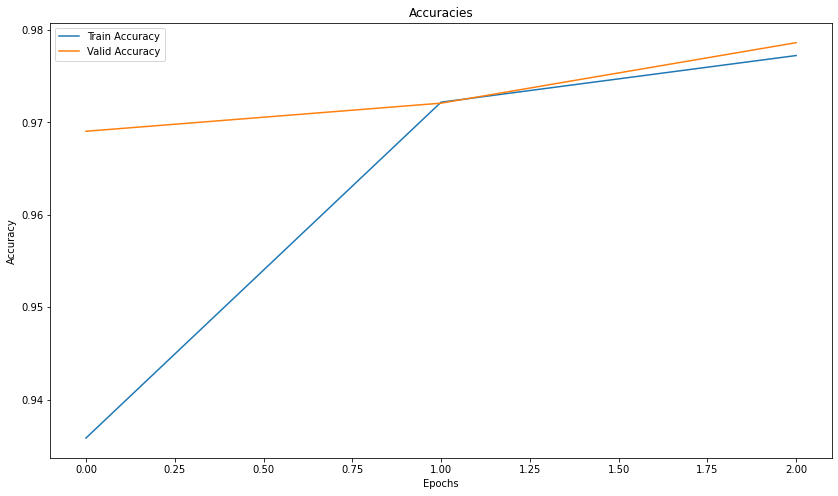

In [16]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [17]:
[loss, accuracy] = model.evaluate(X_valid, y_valid)
print("Loss:%1.3f, Accuracy:%1.3f" % (loss, accuracy))

102/102 [==============================] - 64s 593ms/step - loss: 0.0714 - accuracy: 0.9779
Loss:0.071, Accuracy:0.978


In [18]:
model.save_pretrained("ner_custom_model")

In [67]:
loaded_model = TFAutoModelForTokenClassification.from_pretrained("ner_custom_model")

Some layers from the model checkpoint at ner_custom_model were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at ner_custom_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


In [1]:
#pred = model.predict(tf.constant(X_valid[1])).logits
#pred = tf.keras.activations.sigmoid(tf.convert_to_tensor(pred)).numpy()

y_probs = model.predict(X_test)[0]

NameError: ignored

In [70]:
tf_prediction = tf.nn.softmax(y_probs, axis=1).numpy()[0]

In [71]:
print(test_samples[0])
print(y_test[0])
print(schema)
#print(len(tf_prediction[0]))
print(tf_prediction[18].argmax(-1))


[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'O'), (',', 'O'), ('CHINA', 'B-PER'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')]
[9 9 9 9 9 9 1 1 1 9 9 9 9 9 9 9 9 9 4 4 4 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
['_', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
3


In [25]:
!zip -r ner_custom_model.zip ner_custom_model

  adding: ner_custom_model/ (stored 0%)
  adding: ner_custom_model/tf_model.h5 (deflated 7%)
  adding: ner_custom_model/config.json (deflated 56%)


In [ ]:
from google.colab import files
files.download('ner_custom_model.zip')

In [28]:
print('x')

x
